### TERRA-REF Season 4 Preprocessing
C. Lisle, Knowledgevis, LLC

Copyright © 2020 KnowledgeVis, LLC. All Rights Reserved.

Redistribution and use, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
2. The name of the author may not be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY KNOWLEDGEVIS, LLC "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [2]:
import pandas as pd

Read in the CSV file that was created using an R procedure.  TERRA-REF publishes how to query through an R interface, so I used this process to generate the CSV.  Then the CSV is read in below and processing continues using Python and PANDAS.  The CSV file is an R "long type" where each measurement is in its own row, under the heading "trait" and its value is in the corresponding "mean" column. 

In [3]:
s4_df = pd.read_csv('/Users/curtislisle/Dropbox/ipython-notebooks/D3M/TERRA/terraref_r/season4date.csv')

/Users/curtislisle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
s4_df.head()['sitename']

0     MAC Field Scanner Season 4 Range 8 Column 8
1     MAC Field Scanner Season 4 Range 8 Column 9
2    MAC Field Scanner Season 4 Range 8 Column 10
3    MAC Field Scanner Season 4 Range 8 Column 12
4     MAC Field Scanner Season 4 Range 9 Column 3
Name: sitename, dtype: object

In [5]:
s4_df.columns

Index(['Unnamed: 0', 'checked', 'result_type', 'id', 'citation_id', 'site_id',
       'treatment_id', 'sitename', 'city', 'lat', 'lon', 'scientificname',
       'commonname', 'genus', 'species_id', 'cultivar_id', 'author',
       'citation_year', 'treatment', 'date', 'time', 'raw_date', 'month',
       'year', 'dateloc', 'trait', 'trait_description', 'mean', 'units', 'n',
       'statname', 'stat', 'notes', 'access_level', 'cultivar', 'entity',
       'method_name', 'view_url', 'edit_url', 'trans_date'],
      dtype='object')

In [6]:
selected = ['id','cultivar','cultivar_id','date','trans_date','sitename','trait','mean','units']
s4sel = s4_df[selected]

In [7]:
s4sel.head()

,id,cultivar,cultivar_id,date,trans_date,sitename,trait,mean,units
0,6004764469,PI570145,6000000961,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 8,canopy_height,13.0,cm
1,6004764470,PI329510,6000000577,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 9,canopy_height,14.0,cm
2,6004764471,PI510757,6000000850,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 10,canopy_height,12.0,cm
3,6004764473,PI329865,6000000815,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 8 Column 12,canopy_height,13.0,cm
4,6004764478,PI569457,6000000935,2017 May 8,2017-05-08 12:00:00,MAC Field Scanner Season 4 Range 9 Column 3,canopy_height,14.0,cm


 If all the measurements were equally distributed, doing a long to wide rollup mechanically using pandas' pivot would work.  However, some measurements started later and ended earlier.  Some measurements are daily, some are hourly (just in August), so we really need to split up this dataset into major subsets:  daily and hourly, then try to pivot these datasets.  Or worse, have to hand convert the entries.  I elected to just write a custom algorithm to gather all the measurements together, indexed by date. 

Write a routine that pivots/rolls up the data by hand, by creating a dictionary with trans_date as its index.  Then we can add measurements one at a time...  This takes a few minutes to run on a circa-2020 CPU.  There is an update line printed every 50k entries processed.  As of when this was released, there were 372k entries total. 

In [8]:
s4hand = {}
count = 0
for i in range(len(s4sel)):
    #if count > 40:
    #    break
    #print(i,s4sel['trans_date'][i])
    
    # if we have never seen this date before, start a new dictionary at this date
    if s4sel['trans_date'][i] not in s4hand.keys():
        s4hand[s4sel['trans_date'][i]] = {}

    # if we have not seen this cultivar before on this date, then add a dictionary for this cultivar.  Is there is a chance we 
    # might lose records here? 
    if s4sel['cultivar_id'][i] not in s4hand[s4sel['trans_date'][i]].keys():
        s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]] = {}
        
    # add this feature to the dictionary for the correct cultivar on this date.  We add a dictionary entry named 
    # from the contents in the 'trait' attribute and pull the value from the 'mean' attribute.  This is the heart
    # of the long to wide format conversion.
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]][s4sel['trait'][i]] = s4sel['mean'][i]
    
    # add the cultivar and the location (split out from the sitename text).  This will be added multiple times,
    # so represents redundant processing, but it works to place the measurements in cultivar and location
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['cultivar_id'] = s4sel['cultivar_id'][i]
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['cultivar'] = s4sel['cultivar'][i]
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['season'] = int(s4sel['sitename'][i].split(' ')[4])
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['range'] = int(s4sel['sitename'][i].split(' ')[6])
    s4hand[s4sel['trans_date'][i]][s4sel['cultivar_id'][i]]['column'] = int(s4sel['sitename'][i].split(' ')[8])
    count += 1
    if (count % 50000) == 0:
        print('in process:',count, 'records ingested so far')
print('entered ',count, 'measurements')


in process: 50000 records ingested so far
in process: 100000 records ingested so far
in process: 150000 records ingested so far
in process: 200000 records ingested so far
in process: 250000 records ingested so far
in process: 300000 records ingested so far
in process: 350000 records ingested so far
entered  372363 measurements


In [9]:
print('how many different datetime events:')
print(len(s4hand.keys()))
#print(s4hand.keys())
print('print ouf the wide tuple of a particular cultivar at a particular datetime:')
print(s4hand['2017-07-08 12:00:00'][6000000861])
print(s4hand['2017-08-08 12:00:00'][6000000861])

how many different datetime events:
3152
print ouf the wide tuple of a particular cultivar at a particular datetime:
{'canopy_height': 192.0, 'cultivar_id': 6000000861, 'cultivar': 'PI526905', 'season': 4, 'range': 46, 'column': 3, 'leaf_angle_mean': 0.46521782152400004, 'leaf_angle_alpha': 1.6835253597400002, 'leaf_angle_beta': 1.4356619889500002, 'leaf_angle_chi': 1.71004921126}
{'canopy_height': 293.0, 'cultivar_id': 6000000861, 'cultivar': 'PI526905', 'season': 4, 'range': 46, 'column': 3, 'leaf_angle_mean': 0.460059049579, 'leaf_angle_alpha': 1.80939043311, 'leaf_angle_beta': 1.5116882921700001, 'leaf_angle_chi': 1.7059298014200002}


So, at this point, we have a dictionary (s4hand) which has keys for each different datetime a measurement was entered.  There are 3152 different datetime entries.  This includes all the dates in August where hand measurements are made.  This dictionary can't be scanned easily in datetime order, but it has accumulated all the tuples.  A single dataframe could be made from this dictionary, but a lot of the entries would be empty, since most datetime entries only contain a subset of the measurements. Measurements are not always at the same time increments, either. The canopy_height and leaf properties, for the most part, are sampled once per day.  These are the only measurements that cover most of the growing season.

If the tuples were the same size, we could generate a full pandas dataframe from this dictionary, using the datetime as the index.  However, some tuples are wider than others, since not all measurements were made each time. After reviewing this data distribution, it seems best to create subdictionaries for a certain date range with consistent entries, and then convert the subdictionaries to dataframes.  This manual process is slow, but it will generate a few small, easier to explore and train-on datasets.

In [10]:
for i in s4hand.keys():
    if i >= '2017-08-01' and i <= '2017-08-03':
        print(i)

2017-08-02 12:00:00
2017-08-02 13:34:00
2017-08-02 13:32:00
2017-08-02 12:10:00
2017-08-02 12:09:00
2017-08-02 11:03:00
2017-08-02 11:01:00
2017-08-02 13:28:00
2017-08-02 13:46:00
2017-08-02 13:45:00
2017-08-02 13:43:00
2017-08-02 13:42:00
2017-08-02 13:38:00
2017-08-02 12:01:00
2017-08-02 11:16:00
2017-08-02 11:13:00
2017-08-02 13:31:00
2017-08-02 12:14:00
2017-08-02 12:13:00
2017-08-02 12:11:00
2017-08-02 12:08:00
2017-08-02 11:07:00
2017-08-02 11:05:00
2017-08-02 11:00:00
2017-08-02 13:36:00
2017-08-02 13:35:00
2017-08-02 13:33:00
2017-08-02 10:26:00
2017-08-02 10:29:00
2017-08-02 10:30:00
2017-08-02 10:36:00
2017-08-02 10:42:00
2017-08-02 10:49:00
2017-08-02 10:55:00
2017-08-02 11:29:00
2017-08-02 11:31:00
2017-08-02 11:34:00
2017-08-02 11:41:00
2017-08-02 11:45:00
2017-08-02 11:46:00
2017-08-02 11:51:00
2017-08-02 11:53:00
2017-08-02 11:54:00
2017-08-02 11:57:00
2017-08-02 12:20:00
2017-08-02 12:33:00
2017-08-02 12:34:00
2017-08-02 12:53:00
2017-08-02 13:01:00
2017-08-02 13:03:00


So August 2nd at noon (not August 1st) is when measurements started being taken every few minutes.  Lets look at a few measurements.  Measurements are organized as a dictionary with keys corresponding to the dates a measurment was taken. Each entry is itself a dictionary with cultivar_id as the key and the value is the "wide format" tuple of what measurements were encountered for that cultivar and time. 

The cultivar_id is a long integer.  This is a dual key to the cultivar name we are used to seeing. Both the ID and the name are used below.  This notebook was originally designed using only the integer IDs, but this didn't match the genetic information, so this notebook has been updated to carry the cultivar name (e.g. "PI536905", etc. ) along, though indexing in the original dictarionary structure is by ID.  Later in this notebook, a cross reference table is built. 

In [11]:
print('there are', len(s4hand['2017-08-02 13:52:00'][6000000962].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:52:00']

there are 43 keys in this observation:


{6000000962: {'absorbance_850': 0.41700000000000004,
  'cultivar_id': 6000000962,
  'cultivar': 'PI570254',
  'season': 4,
  'range': 45,
  'column': 4,
  'roll': -14.82,
  'PhiNO': 0.14400000000000002,
  'PhiNPQ': 0.6,
  'absorbance_530': 1.2,
  'absorbance_605': 1.466,
  'absorbance_730': 0.376,
  'absorbance_880': 0.46,
  'absorbance_940': 0.46,
  'Fs': 4298.7,
  'NPQt': 4.154,
  'qL': 0.363,
  'qP': 0.526,
  'RFd': 0.344,
  'SPAD_530': 73.96,
  'SPAD_605': 100.57,
  'SPAD_730': -8.39,
  'leaf_thickness': 0.28,
  'ambient_humidity': 39.557617,
  'leaf_angle_clamp_position': 14.87,
  'pitch': -1.28,
  'proximal_air_temperature': 40.139998999999996,
  'FvP/FmP': 0.486,
  'gH+': 0.0,
  'ECSt': 0.0,
  'leaf_temperature_differential': -6.329999,
  'Phi2': 0.256,
  'relative_chlorophyll': 48.84512428,
  'FmPrime': 5777.98,
  'FoPrime': 2968.0,
  'LEF': 174.076,
  'SPAD_420': 164.67,
  'SPAD_650': 48.85,
  'SPAD_850': -4.34,
  'SPAD_880': 0.01,
  'light_intensity_PAR': 1511.0,
  'vH+': 0.0

In [12]:
print('there are', len(s4hand['2017-08-02 13:53:00'][6000000962].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:53:00']

there are 26 keys in this observation:


{6000000962: {'absorbance_850': 0.41200000000000003,
  'cultivar_id': 6000000962,
  'cultivar': 'PI570254',
  'season': 4,
  'range': 45,
  'column': 4,
  'roll': 28.54,
  'PhiNO': 0.221,
  'PhiNPQ': 0.54,
  'absorbance_530': 1.094,
  'absorbance_605': 1.348,
  'absorbance_730': 0.36200000000000004,
  'absorbance_880': 0.461,
  'absorbance_940': 0.457,
  'Fs': 5446.8,
  'NPQt': 2.447,
  'qL': 0.222,
  'qP': 0.408,
  'RFd': 0.314,
  'SPAD_530': 63.77,
  'SPAD_605': 89.11,
  'SPAD_730': -9.46,
  'leaf_thickness': 0.25,
  'ambient_humidity': 39.856445,
  'leaf_angle_clamp_position': 32.96,
  'pitch': 17.23}}

In [13]:
print('there are', len(s4hand['2017-08-02 13:11:00'][6000000851].keys()), 'keys in this observation:')
s4hand['2017-08-02 13:11:00']

there are 42 keys in this observation:


{6000000851: {'absorbance_850': 0.396,
  'cultivar_id': 6000000851,
  'cultivar': 'PI511355',
  'season': 4,
  'range': 26,
  'column': 15,
  'roll': -55.82,
  'PhiNO': 0.195,
  'PhiNPQ': 0.51,
  'absorbance_530': 1.131,
  'absorbance_605': 1.374,
  'absorbance_730': 0.35700000000000004,
  'absorbance_880': 0.446,
  'absorbance_940': 0.441,
  'Fs': 4951.5,
  'NPQt': 2.617,
  'qL': 0.31,
  'qP': 0.513,
  'RFd': 0.418,
  'SPAD_530': 69.06,
  'SPAD_605': 93.29,
  'SPAD_730': -8.34,
  'leaf_thickness': 0.1,
  'ambient_humidity': 39.974609,
  'leaf_angle_clamp_position': 57.04,
  'pitch': 14.43,
  'proximal_air_temperature': 39.82,
  'FvP/FmP': 0.574,
  'gH+': 5.7015,
  'ECSt': 0.0012,
  'leaf_temperature_differential': -1.63,
  'Phi2': 0.295,
  'relative_chlorophyll': 46.43594646,
  'FmPrime': 7021.161999999999,
  'FoPrime': 2989.0,
  'LEF': 141.406,
  'SPAD_420': 158.94,
  'SPAD_650': 46.44,
  'SPAD_850': -4.48,
  'SPAD_880': 0.47,
  'light_intensity_PAR': 1066.0,
  'vH+': 0.00020228}}

Sometimes the cultivar numeric index is used as the cultivar_id, sometimes it has the character name (e.g. 'cultivar_id': 6000000962,
  'cultivar': 'PI570254').  Hand measurements during August seem to have the cultivar_id entered as the cultivar, so build a cross reference by traversing the dictionary

In [14]:
cultivar_xref = {}
for key in s4hand.keys():
    # look in all the records on this date and record any names we find
    for thiscultivar in s4hand[key]:
        # now we are looking at the dictionary of measurements for a single cultivar. If the _id and cultivar name don't match, we can
        # learn from this record, so make an entry in the cross reference dictionary
        if s4hand[key][thiscultivar]['cultivar'] != s4hand[key][thiscultivar]['cultivar_id']:
            cultivar_xref[s4hand[key][thiscultivar]['cultivar']] = s4hand[key][thiscultivar]['cultivar_id']
            cultivar_xref[s4hand[key][thiscultivar]['cultivar_id']] = s4hand[key][thiscultivar]['cultivar']
    

In [19]:
# lets see what our bi-directional index looks like.  There are a few odd names, but this doesn't show unless 
# we print the whole dictionary.  Lets just sample the dictionary for reasonability
count = 0
for key in cultivar_xref:
    print(key, cultivar_xref[key])
    count += 1
    if count>15:
        break

PI570145 6000000961
6000000961 PI570145
PI329510 6000000577
6000000577 PI329510
PI510757 6000000850
6000000850 PI510757
PI329865 6000000815
6000000815 PI329865
PI569457 6000000935
6000000935 PI569457
PI521152 6000000855
6000000855 PI521152
PI569452 6000000931
6000000931 PI569452
PI585961 6000000982
6000000982 PI585961


### try generating histograms of the tuple width

lets explore the coverage of the dictionary by cycling through it and listing how many measurements are on each day and build a histogram of the measurement count. **this is not correct because of the cultivar key**

In [20]:
widths = []
for key in s4hand.keys():
    # how many measurements are on this datetime. accumulate in a histogram dictionary
    cultivars = s4hand[key]
    # check just the first entry.  We are assuming they are all the same width.  This is probably naive, but it will get us something
    for cultivar in cultivars:
        measurement_width = len(s4hand[key][cultivar].keys())
        widths.append(measurement_width)
        break
print('we found the tuple width of',len(widths), 'different measurements')

we found the tuple width of 3152 different measurements


In [78]:
import heapq
from itertools import count
cnt = count()
heap = []
for key in histo_date:
    heapq.heappush(heap, (histo_date[key], next(cnt), key))
#heap
heapq.nlargest(10, heap, key=None)

[(3002, 2, 1),
 (49, 5, 351),
 (11, 20, 349),
 (9, 47, 18),
 (7, 42, 35),
 (2, 54, 13),
 (2, 49, 63),
 (2, 48, 55),
 (2, 44, 52),
 (2, 36, 336)]

it might make more sense to organize the heap with the number of elements first...

In [81]:
import heapq
from itertools import count
cnt = count()
heap = []
for key in histo_date:
    heapq.heappush(heap, (key,  next(cnt), histo_date[key]))
#heap
heapq.nlargest(20, heap, key=None)

[(351, 5, 49),
 (349, 20, 11),
 (346, 50, 1),
 (344, 22, 2),
 (341, 29, 1),
 (339, 13, 1),
 (337, 26, 1),
 (336, 36, 2),
 (334, 38, 1),
 (333, 55, 1),
 (332, 24, 2),
 (331, 39, 1),
 (329, 21, 1),
 (328, 56, 1),
 (326, 37, 1),
 (324, 35, 2),
 (318, 28, 1),
 (313, 6, 1),
 (304, 57, 1),
 (296, 8, 2)]

### Extract date regions of consistent measurements

Going back to filtering the original event dictionary, lets try to make a dataframe of only the August timeframe (where many hand-made measurements were taken).  There are 4573 entries without filtering. 

In [36]:
augustList = []
dateList = []
for key in s4hand.keys():
    if (key > '2017-08-02 00:00:00') and (key < '2017-08-31 00:00:00'):
        cultivar_keys = s4hand[key].keys()
        for k in cultivar_keys:
            record = s4hand[key][k]
            if len(record.keys()) > 30:
                #print(key)
                #print(record)
                #break
                record['cultivar_id'] = k
                # look up the textual name of the cultivar so we can match against the tree
                record['cultivar'] = cultivar_xref[k]
                record['date'] = key
                # delete columns that are missing data
                if 'ECSt' in record:
                    del record['ECSt']
                if 'gH+' in record:
                    del record['gH+']
                if 'vH+' in record:
                    del record['vH+']
                if 'absorbance_420' in record:
                    del record['absorbance_420']
                if 'absorbance_650' in record:
                    del record['absorbance_650']
                augustList.append(record)
                dateList.append(key)
        #break
print(len(augustList))

949


In [37]:
import pandas as pd
august_df = pd.DataFrame(augustList,index=dateList)
august_df.head()

,FmPrime,FoPrime,Fs,FvP/FmP,LEF,NPQt,Phi2,PhiNO,PhiNPQ,RFd,...,leaf_thickness,light_intensity_PAR,pitch,proximal_air_temperature,qL,qP,range,relative_chlorophyll,roll,season
2017-08-28 12:00:00,2986.150,2233.0,2316.8,0.252,157.363,13.480,0.224,0.054,0.722,0.289,...,0.42,1560.0,1.92,44.490002,0.857,0.889,21,34.795411,-2.60,4
2017-08-28 11:14:00,4181.791,2583.0,3221.0,0.382,158.183,6.886,0.230,0.098,0.673,0.298,...,0.15,1530.0,36.11,43.740002,0.482,0.601,26,49.602294,-39.74,4
2017-08-28 11:15:00,5116.053,2321.0,3569.2,0.546,177.017,3.051,0.302,0.172,0.525,0.433,...,0.57,1301.0,5.31,43.770000,0.360,0.553,26,46.183556,-17.32,4
2017-08-28 11:59:00,1902.247,1759.0,1757.1,0.076,53.598,58.729,0.076,0.015,0.908,0.083,...,0.46,1561.0,-1.62,43.950001,1.011,1.010,21,33.009560,-0.90,4
2017-08-28 12:10:00,1749.371,1476.0,1512.8,0.156,94.147,25.393,0.135,0.033,0.832,0.156,...,1.08,1547.0,12.25,45.700001,0.846,0.867,45,34.042065,11.29,4


In [38]:
august_df.columns

Index(['FmPrime', 'FoPrime', 'Fs', 'FvP/FmP', 'LEF', 'NPQt', 'Phi2', 'PhiNO',
       'PhiNPQ', 'RFd', 'SPAD_420', 'SPAD_530', 'SPAD_605', 'SPAD_650',
       'SPAD_730', 'SPAD_850', 'SPAD_880', 'absorbance_530', 'absorbance_605',
       'absorbance_730', 'absorbance_850', 'absorbance_880', 'absorbance_940',
       'ambient_humidity', 'column', 'cultivar', 'cultivar_id', 'date',
       'leaf_angle_clamp_position', 'leaf_temperature',
       'leaf_temperature_differential', 'leaf_thickness',
       'light_intensity_PAR', 'pitch', 'proximal_air_temperature', 'qL', 'qP',
       'range', 'relative_chlorophyll', 'roll', 'season'],
      dtype='object')

In [39]:
august_df['cultivar']

2017-08-28 12:00:00    PI570373
2017-08-28 11:14:00    PI511355
2017-08-28 11:15:00    PI511355
2017-08-28 11:59:00    PI570373
2017-08-28 12:10:00    PI570373
2017-08-28 12:12:00    PI570373
2017-08-28 12:17:00    PI570254
2017-08-28 12:20:00    PI570254
2017-08-28 12:30:00    PI570254
2017-08-28 12:31:00    PI570254
2017-08-28 12:32:00    PI570254
2017-08-28 12:39:00    PI651491
2017-08-28 12:40:00    PI651491
2017-08-28 13:13:00    PI511355
2017-08-28 13:15:00    PI511355
2017-08-28 13:16:00    PI511355
2017-08-28 13:23:00    PI570254
2017-08-28 13:25:00    PI570254
2017-08-28 13:26:00    PI570254
2017-08-28 13:39:00    PI570254
2017-08-28 13:40:00    PI570254
2017-08-28 13:41:00    PI570254
2017-08-28 13:46:00    PI570373
2017-08-28 13:47:00    PI570373
2017-08-28 13:48:00    PI570373
2017-08-28 13:56:00    PI570373
2017-08-28 14:19:00    PI651491
2017-08-28 14:21:00    PI651491
2017-08-28 14:22:00    PI651491
2017-08-28 14:25:00    PI511355
                         ...   
2017-08-

In [40]:
august_df.to_csv("s4_august_by_hand_30plus.csv",index=False)

Go back and look at the records during this period that have fewer entries:

In [173]:
augustListSmall = []
dateListSmall = []
for key in s4hand.keys():
    if (key > '2017-08-02 00:00:00') and (key < '2017-08-31 00:00:00'):
        cultivar_keys = s4hand[key].keys()
        for k in cultivar_keys:
            record = s4hand[key][k]
            if len(record.keys()) == 9:
                #print(key)
                #print(record)
                #break
                record['cultivar'] = k
                record['date'] = key
                # delete columns that are missing data
                if 'ECSt' in record:
                    del record['ECSt']
                if 'gH+' in record:
                    del record['gH+']
                if 'flavonol_index' in record:
                    del record['flavonol_index']
                if 'NBI_nitrogen_balance_index' in record:
                    del record['NBI_nitrogen_balance_index']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' not in record:
                    augustListSmall.append(record)
                    dateListSmall.append(key)
        #break
print(len(augustListSmall))

533


In [174]:
import pandas as pd
august_short_df = pd.DataFrame(augustListSmall,index=dateListSmall)
august_short_df.head()

,column,cultivar,cultivar_id,date,panicle_count,panicle_surface_area,panicle_volume,range,season
2017-08-21 12:00:00,12,6000001059,6000001059,2017-08-21 12:00:00,8.0,16033.582107,99161.303913,14,4
2017-08-21 12:00:00,6,6000000214,6000000214,2017-08-21 12:00:00,4.0,8154.624339,37914.725971,15,4
2017-08-21 12:00:00,10,6000000919,6000000919,2017-08-21 12:00:00,5.0,20663.535212,160338.920662,17,4
2017-08-21 12:00:00,6,6000000739,6000000739,2017-08-21 12:00:00,46.0,11581.658116,72110.068074,18,4
2017-08-21 12:00:00,7,6000000945,6000000945,2017-08-21 12:00:00,16.0,19284.814669,165901.952211,18,4


In [175]:
august_short_df.columns

Index(['column', 'cultivar', 'cultivar_id', 'date', 'panicle_count',
       'panicle_surface_area', 'panicle_volume', 'range', 'season'],
      dtype='object')

In [176]:
august_short_df.to_csv("s4_august_by_hand_panicle.csv",index=False)

In [41]:
augustListSmall = []
dateListSmall = []
for key in s4hand.keys():
    if (key > '2017-08-02 00:00:00') and (key < '2017-08-31 00:00:00'):
        cultivar_keys = s4hand[key].keys()
        for k in cultivar_keys:
            record = s4hand[key][k]
            if 'canopy_height' in record and ('leaf_angle_alpha' in record):
                #print(key)
                #print(record)
                #break
                # delete columns that are missing data
                if 'panicle_count' in record:
                    del record['panicle_count']
                if 'panicle_surface_area' in record:
                    del record['panicle_surface_area']
                if 'panicle_volume' in record:
                    del record['panicle_volume']
                if 'surface_temperature' in record:
                    del record['surface_temperature']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' not in record:
                    augustListSmall.append(record)
                    dateListSmall.append(key)
        #break
print(len(augustListSmall))

1531


In [42]:
import pandas as pd
august_short_df = pd.DataFrame(augustListSmall,index=dateListSmall)
august_short_df.head()

,canopy_height,column,cultivar,cultivar_id,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,range,season
2017-08-21 12:00:00,347.0,12,Big_Kahuna,6000001055,1.647406,1.380916,1.744574,0.459114,54,4
2017-08-21 12:00:00,342.0,9,SP1615,6000001054,1.929799,1.585717,1.681774,0.466760,53,4
2017-08-22 12:00:00,329.0,6,PI302252,6000000552,1.882103,1.399877,1.874146,0.437437,4,4
2017-08-22 12:00:00,338.0,7,PI156217,6000000710,1.565166,1.350248,1.717977,0.468847,4,4
2017-08-22 12:00:00,287.0,13,PI643008,6000001009,1.147330,1.119141,1.732140,0.479783,6,4


In [44]:
returnUniqueCounts(august_short_df)

,Column_Name,Num_Unique
9,season,1
1,column,15
8,range,53
0,canopy_height,148
2,cultivar,273
3,cultivar_id,273
5,leaf_angle_beta,1530
6,leaf_angle_chi,1530
4,leaf_angle_alpha,1531
7,leaf_angle_mean,1531


In [45]:
august_short_df.to_csv("s4_august_by_hand_leaf.csv",index=False)

In [187]:
augustListSmall = []
dateListSmall = []
for key in s4hand.keys():
    if (key > '2017-08-02 00:00:00') and (key < '2017-08-31 00:00:00'):
        cultivar_keys = s4hand[key].keys()
        for k in cultivar_keys:
            record = s4hand[key][k]
            if ('canopy_height' in record) and ('leaf_angle_alpha' in record) and ('panicle_count' in record):
                #print(key)
                #print(record)
                #break
                # delete columns that are missing data
                if 'surface_temperature' in record:
                    del record['surface_temperature']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' in record:
                    del record['chlorophyll_index']
                augustListSmall.append(record)
                dateListSmall.append(key)
        #break
print(len(augustListSmall))

0


So there aren't any entries during August that have both panicle data and leaf data in the same measurement.  These are probably listed under different datetime values...sigh.  Pivot back to the full dataset and extract as many full tuples as possible...

In [9]:
augustListFull = []
dateListFull = []
for key in s4hand.keys():
    cultivar_keys = s4hand[key].keys()
    for k in cultivar_keys:
        record = s4hand[key][k]
        if ('canopy_height' in record) and ('leaf_angle_alpha' in record) and ('leaf_angle_beta' in record):
            record['cultivar'] = k
            record['date'] = key
            #print(key)
            #print(record)
            #break
            # delete columns that are missing data
            if 'panicle_count' in record:
                del record['panicle_count']
            if 'panicle_surface_area' in record:
                del record['panicle_surface_area']
            if 'panicle_volume' in record:
                del record['panicle_volume']
            if 'surface_temperature' in record:
                del record['surface_temperature']
            if 'chlorophyll_index' in record:
                del record['chlorophyll_index']
            if 'leaf_temperature' in record:
                del record['leaf_temperature']
            if 'absorbance_730' in record:
                del record['chlorophyll_index']
            if 'cultivar_id' in record:
                del record['cultivar_id']
            augustListFull.append(record)
            dateListFull.append(key)
        #break
print(len(augustListFull))

full_df = pd.DataFrame(augustListFull,index=dateListFull)
full_df.head()

9441


,canopy_height,column,cultivar,date,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,range,season
2017-05-13 12:00:00,15.0,2,6000000836,2017-05-13 12:00:00,2.695956,1.977380,1.756464,0.435924,43,4
2017-05-13 12:00:00,15.0,15,6000000462,2017-05-13 12:00:00,3.265980,2.018623,1.941012,0.396782,35,4
2017-05-13 12:00:00,19.0,2,6000000751,2017-05-13 12:00:00,2.159610,1.809209,1.638744,0.471944,42,4
2017-05-13 12:00:00,13.0,4,6000000916,2017-05-13 12:00:00,3.042180,2.198751,1.732985,0.444099,30,4
2017-05-15 12:00:00,17.0,2,6000000976,2017-05-15 12:00:00,2.305345,1.872028,1.665387,0.462600,45,4


In [27]:
full_df.describe()

,canopy_height,column,cultivar,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,range,season,day_offset
count,9441.000000,9441.000000,9.441000e+03,9441.000000,9441.000000,9441.000000,9441.000000,9441.000000,9441.0,9441
mean,197.719203,8.541468,6.000001e+09,2.903153,1.825797,1.908666,0.419339,30.267027,4.0,56 days 22:01:56.682554
std,96.712778,4.004024,2.002971e+02,1.076542,0.321239,0.243674,0.052055,14.455791,0.0,27 days 09:36:26.746864
min,12.000000,1.000000,6.000000e+09,0.756692,0.977342,0.756736,0.246258,2.000000,4.0,12 days 00:00:00
25%,114.000000,5.000000,6.000001e+09,2.103990,1.590333,1.767434,0.386807,18.000000,4.0,36 days 00:00:00
50%,208.000000,9.000000,6.000001e+09,2.846314,1.817881,1.906026,0.416412,32.000000,4.0,55 days 00:00:00
75%,271.000000,12.000000,6.000001e+09,3.540884,2.040797,2.048274,0.449578,43.000000,4.0,65 days 00:00:00
max,412.000000,16.000000,6.000001e+09,8.647608,4.171909,4.768680,0.684988,54.000000,4.0,121 days 00:00:00


In [199]:
full_df.to_csv("s4_full_height_leaf.csv",index=False)

In [43]:
def returnUniqueCounts(dframe):
    return pd.DataFrame.from_records([(col, dframe[col].nunique()) for col in dframe.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

In [29]:
returnUniqueCounts(full_df)

,Column_Name,Num_Unique
9,season,1
1,column,16
8,range,53
3,date,55
10,day_offset,55
2,cultivar,351
0,canopy_height,395
4,leaf_angle_alpha,9441
5,leaf_angle_beta,9441
6,leaf_angle_chi,9441


convert the date to a day offset into the year, so we can get an integer to pass into a model.

In [30]:
full_df.dtypes

canopy_height               float64
column                        int64
cultivar                      int64
date                 datetime64[ns]
leaf_angle_alpha            float64
leaf_angle_beta             float64
leaf_angle_chi              float64
leaf_angle_mean             float64
range                         int64
season                        int64
day_offset          timedelta64[ns]
dtype: object

In [20]:
full_df['date'] = pd.to_datetime(full_df['date'])

In [21]:
from datetime import datetime
print(datetime.strptime('2017-05-01 12:00:00', '%Y-%m-%d %H:%M:%S'))

2017-05-01 12:00:00


In [43]:
# add an offset column that subtracts a "start date" from each of the datetimes in the samples.  This will give us an offset in days
full_df['day_offset'] = full_df['date'] - datetime.strptime('2017-05-01 12:00:00', '%Y-%m-%d %H:%M:%S')

In [44]:
# here is how a timedelta offset is converted to its component part
full_df['day_offset'][0].days

12

In [45]:
# pandas series don't like the df['column'].dt.days notation, so just convert to an int. Divide by the number of microseconds in a day
full_df['day_offset'] = full_df['day_offset'].astype('int64')/ 86400000000000
full_df.head()

,canopy_height,column,cultivar,date,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,range,season,day_offset
2017-05-13 12:00:00,15.0,2,6000000836,2017-05-13 12:00:00,2.695956,1.977380,1.756464,0.435924,43,4,12.0
2017-05-13 12:00:00,15.0,15,6000000462,2017-05-13 12:00:00,3.265980,2.018623,1.941012,0.396782,35,4,12.0
2017-05-13 12:00:00,19.0,2,6000000751,2017-05-13 12:00:00,2.159610,1.809209,1.638744,0.471944,42,4,12.0
2017-05-13 12:00:00,13.0,4,6000000916,2017-05-13 12:00:00,3.042180,2.198751,1.732985,0.444099,30,4,12.0
2017-05-15 12:00:00,17.0,2,6000000976,2017-05-15 12:00:00,2.305345,1.872028,1.665387,0.462600,45,4,14.0


In [246]:
full_df.to_csv("s4_full_height_leaf_day.csv",index=False)

### look at how grouping measurements by cultivar and location could be done

In [247]:
len(full_df.groupby(['cultivar','column','range']).groups)

727

In [248]:
print(full_df.groupby(['cultivar','column','range']).groups[(6000000207, 3, 39)])

Index(['2017-05-16 12:00:00', '2017-05-25 12:00:00', '2017-06-02 12:00:00',
       '2017-06-03 12:00:00', '2017-06-05 12:00:00', '2017-06-06 12:00:00',
       '2017-06-08 12:00:00', '2017-06-09 12:00:00', '2017-06-10 12:00:00',
       '2017-08-25 12:00:00', '2017-08-26 12:00:00', '2017-08-29 12:00:00',
       '2017-07-05 12:00:00', '2017-06-16 12:00:00', '2017-06-25 12:00:00',
       '2017-07-01 12:00:00', '2017-07-02 12:00:00', '2017-06-24 12:00:00',
       '2017-07-04 12:00:00'],
      dtype='object')


In [249]:
count = 0
for group in full_df.groupby(['cultivar','column','range']).groups:
    print(group)
    count += 1
    if count>5:
        break

(6000000207, 3, 39)
(6000000207, 9, 23)
(6000000208, 14, 26)
(6000000208, 15, 30)
(6000000209, 4, 39)
(6000000209, 13, 23)


In [220]:
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    print(name)
    print(group)
    break

(6000000207, 3, 39)
                     canopy_height  column    cultivar                 date  \
2017-05-16 12:00:00           22.0       3  6000000207  2017-05-16 12:00:00   
2017-05-25 12:00:00           48.0       3  6000000207  2017-05-25 12:00:00   
2017-06-02 12:00:00           89.0       3  6000000207  2017-06-02 12:00:00   
2017-06-03 12:00:00           95.0       3  6000000207  2017-06-03 12:00:00   
2017-06-05 12:00:00          113.0       3  6000000207  2017-06-05 12:00:00   
2017-06-06 12:00:00          116.0       3  6000000207  2017-06-06 12:00:00   
2017-06-08 12:00:00          132.0       3  6000000207  2017-06-08 12:00:00   
2017-06-09 12:00:00          141.0       3  6000000207  2017-06-09 12:00:00   
2017-06-10 12:00:00          150.0       3  6000000207  2017-06-10 12:00:00   
2017-08-25 12:00:00          317.0       3  6000000207  2017-08-25 12:00:00   
2017-08-26 12:00:00          317.0       3  6000000207  2017-08-26 12:00:00   
2017-08-29 12:00:00          318

## Fit Models to the Season 4 extraction

In [2]:
import sklearn
import pandas as pd

In [253]:
# paste code from another notebook that uses 'cdf' as the source dataframe.  It 
# is easier to just copy to that same variable name
cdf = full_df

In [254]:
cdf.head()

,canopy_height,column,cultivar,date,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,range,season,day_offset
2017-05-13 12:00:00,15.0,2,6000000836,2017-05-13 12:00:00,2.695956,1.977380,1.756464,0.435924,43,4,12
2017-05-13 12:00:00,15.0,15,6000000462,2017-05-13 12:00:00,3.265980,2.018623,1.941012,0.396782,35,4,12
2017-05-13 12:00:00,19.0,2,6000000751,2017-05-13 12:00:00,2.159610,1.809209,1.638744,0.471944,42,4,12
2017-05-13 12:00:00,13.0,4,6000000916,2017-05-13 12:00:00,3.042180,2.198751,1.732985,0.444099,30,4,12
2017-05-15 12:00:00,17.0,2,6000000976,2017-05-15 12:00:00,2.305345,1.872028,1.665387,0.462600,45,4,14


In [255]:
train_df = cdf[['cultivar','day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
target_df = cdf['canopy_height']

In [256]:
X_train = train_df.values
y_train = target_df.values
print(X_train.shape)
print(y_train.shape)

(9441, 8)
(9441,)


In [265]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor

tree = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
#svm_mod = svm.SVR().fit(X_train, y_train)
gbr_mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)

pred_tree = tree.predict(X_train)
pred_lr = linear_reg.predict(X_train)
#pred_svm = svm_mod.predict(X_train)
pred_gbr = gbr_mod.predict(X_train)


In [266]:
cdf['decision_tree'] = pred_tree
cdf['linearRegression'] = pred_lr
#cdf['svm'] = pred_svm
cdf['gboost'] = pred_gbr
cdf.head()

,canopy_height,column,cultivar,date,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,range,season,day_offset,decision_tree,linearRegression,gboost
2017-05-13 12:00:00,15.0,2,6000000836,2017-05-13 12:00:00,2.695956,1.977380,1.756464,0.435924,43,4,12,20.684211,42.190178,19.914282
2017-05-13 12:00:00,15.0,15,6000000462,2017-05-13 12:00:00,3.265980,2.018623,1.941012,0.396782,35,4,12,16.200000,51.816082,15.886342
2017-05-13 12:00:00,19.0,2,6000000751,2017-05-13 12:00:00,2.159610,1.809209,1.638744,0.471944,42,4,12,20.684211,47.519900,22.397037
2017-05-13 12:00:00,13.0,4,6000000916,2017-05-13 12:00:00,3.042180,2.198751,1.732985,0.444099,30,4,12,16.200000,44.521976,16.628871
2017-05-15 12:00:00,17.0,2,6000000976,2017-05-15 12:00:00,2.305345,1.872028,1.665387,0.462600,45,4,14,20.684211,50.301563,19.387769


            canopy_height  decision_tree      gboost
day_offset                                          
12                   15.0      20.684211   19.914282
15                   29.0      20.684211   24.810587
32                  102.0      90.363636   96.840969
35                  119.0     110.971963  114.542491
36                  125.0     109.250000  125.781571
38                  111.0     113.250000  116.642920
39                  114.0     114.866667  118.596735
40                  272.0     190.500000  241.614416
46                  191.0     183.476190  186.047126
55                  248.0     244.583333  242.984222
61                  278.0     255.428571  257.851301
62                  260.0     272.200000  258.050972
64                  263.0     274.647887  264.090317
65                  268.0     274.647887  263.217710
120                 386.0     318.171875  370.444316


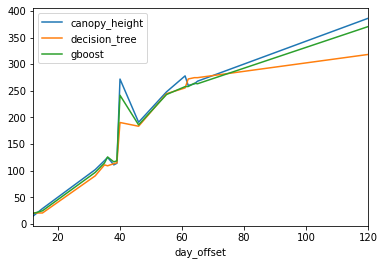

In [267]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_cultivar(fulldf,cultivar):
    df = fulldf.loc[fulldf['cultivar'] == cultivar]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    #print(df.shape)
    df = df[['day_offset','canopy_height','decision_tree','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()

#plot_cultivar(cdf,'PI145619')
plot_cultivar(cdf,6000000836)

            canopy_height  decision_tree      gboost
day_offset                                          
33                   96.0      93.184211   95.295526
35                   90.0     101.326087   89.041657
36                   97.0     112.330508   97.400502
39                  115.0     128.512821  121.455541
40                  128.0     128.145455  126.195282
45                  151.0     168.659722  152.864520
46                  156.0     175.333333  157.547256
47                  168.0     182.545455  168.697935
54                  224.0     227.835294  217.687636
55                  213.0     233.208791  215.623566
56                  223.0     221.681818  222.594397
60                  238.0     240.298013  239.141691
61                  241.0     246.661417  245.439149
65                  264.0     268.322917  264.207241
68                  275.0     273.623229  275.614637
117                 326.0     330.142857  330.534632


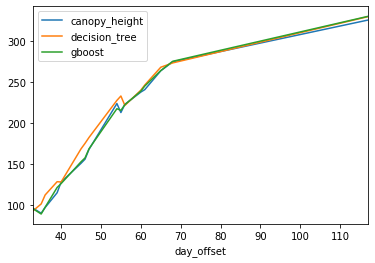

In [268]:
plot_cultivar(cdf,6000000462)

            canopy_height  decision_tree      gboost
day_offset                                          
14                   17.0      20.684211   19.387769
18                   25.0      23.906250   22.868977
32                   83.0      90.363636   83.121168
33                   92.0      91.794872   88.127969
35                  103.0     110.971963  103.402695
36                  103.0     109.250000   99.482699
38                   98.0     139.500000  108.437526
39                  100.0     119.666667  111.939874
45                  124.0     138.250000  148.556495


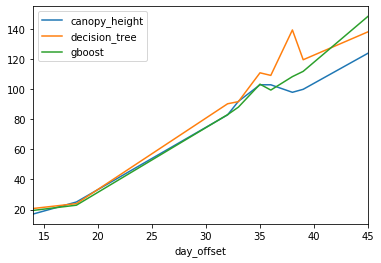

In [269]:
plot_cultivar(cdf,6000000976)

Try to visualize the results across the field by finding the delta at each location between the observed and the model output.  Try to use Vega or VegaLite. Checkout the native integration explained here: https://github.com/jupyterlab/jupyterlab/blob/master/examples/vega/vega-extension.ipynb

In [85]:
from IPython.display import display
import pandas as pd

def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v4+json'] = spec
    display(bundle, raw=True)

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v2+json'] = spec
    display(bundle, raw=True)

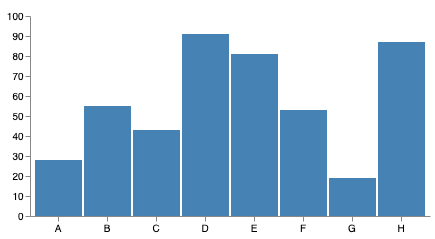

In [87]:
Vega({
  "$schema": "https://vega.github.io/schema/vega/v3.0.json",
  "width": 400,
  "height": 200,
  "padding": 5,

  "data": [
    {
      "name": "table",
      "values": [
        {"category": "A", "amount": 28},
        {"category": "B", "amount": 55},
        {"category": "C", "amount": 43},
        {"category": "D", "amount": 91},
        {"category": "E", "amount": 81},
        {"category": "F", "amount": 53},
        {"category": "G", "amount": 19},
        {"category": "H", "amount": 87}
      ]
    }
  ],

  "signals": [
    {
      "name": "tooltip",
      "value": {},
      "on": [
        {"events": "rect:mouseover", "update": "datum"},
        {"events": "rect:mouseout",  "update": "{}"}
      ]
    }
  ],

  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {"data": "table", "field": "category"},
      "range": "width",
      "padding": 0.05,
      "round": True
    },
    {
      "name": "yscale",
      "domain": {"data": "table", "field": "amount"},
      "nice": True,
      "range": "height"
    }
  ],

  "axes": [
    { "orient": "bottom", "scale": "xscale" },
    { "orient": "left", "scale": "yscale" }
  ],

  "marks": [
    {
      "type": "rect",
      "from": {"data":"table"},
      "encode": {
        "enter": {
          "x": {"scale": "xscale", "field": "category"},
          "width": {"scale": "xscale", "band": 1},
          "y": {"scale": "yscale", "field": "amount"},
          "y2": {"scale": "yscale", "value": 0}
        },
        "update": {
          "fill": {"value": "steelblue"}
              },
        "hover": {
          "fill": {"value": "red"}
        }
      }
    },
    {
      "type": "text",
      "encode": {
        "enter": {
          "align": {"value": "center"},
          "baseline": {"value": "bottom"},
          "fill": {"value": "#333"}
        },
        "update": {
          "x": {"scale": "xscale", "signal": "tooltip.category", "band": 0.5},
          "y": {"scale": "yscale", "signal": "tooltip.amount", "offset": -2},
          "text": {"signal": "tooltip.amount"},
          "fillOpacity": [
            {"test": "datum === tooltip", "value": 0},
            {"value": 1}
          ]
        }
      }
    }
  ]
})

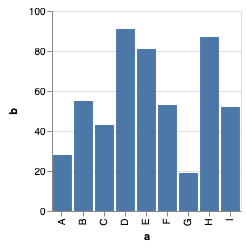

In [86]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v2.json",
  "description": "A simple bar chart with embedded data.",
  "data": {
    "values": [
      {"a": "A","b": 28}, {"a": "B","b": 55}, {"a": "C","b": 43},
      {"a": "D","b": 91}, {"a": "E","b": 81}, {"a": "F","b": 53},
      {"a": "G","b": 19}, {"a": "H","b": 87}, {"a": "I","b": 52}
    ]
  },
  "mark": "bar",
  "encoding": {
    "x": {"field": "a", "type": "ordinal"},
    "y": {"field": "b", "type": "quantitative"}
  }
})

In [92]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {"url": "data/movies.json"},
  "spacing": 15,
  "bounds": "flush",
  "vconcat": [{
    "mark": "bar",
    "height": 60,
    "encoding": {
      "x": {
        "bin": True,
        "field": "IMDB_Rating",
        "type": "quantitative",
        "axis": None
      },
      "y": {
        "aggregate": "count",
        "type": "quantitative",
        "scale": {
          "domain": [0,1000]
        },
        "title": ""
      }
    }
  }, {
    "spacing": 15,
    "bounds": "flush",
    "hconcat": [{
      "mark": "rect",
      "encoding": {
        "x": {
          "bin": True,
          "field": "IMDB_Rating",
          "type": "quantitative"
        },
        "y": {
          "bin": True,
          "field": "Rotten_Tomatoes_Rating",
          "type": "quantitative"
        },
        "color": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }, {
      "mark": "bar",
      "width": 60,
      "encoding": {
        "y": {
          "bin": True,
          "field": "Rotten_Tomatoes_Rating",
          "type": "quantitative",
          "axis": None
        },
        "x": {
          "aggregate": "count",
          "type": "quantitative",
          "scale": {
            "domain": [0,1000]
          },
          "title": ""
        }
      }
    }]
  }],
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
})


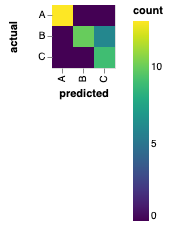

In [94]:
VegaLite({
  "data": {
    "values": [
      {"actual": "A", "predicted": "A", "count": 13},
      {"actual": "A", "predicted": "B", "count": 0},
      {"actual": "A", "predicted": "C", "count": 0},
      {"actual": "B", "predicted": "A", "count": 0},
      {"actual": "B", "predicted": "B", "count": 10},
      {"actual": "B", "predicted": "C", "count": 6},
      {"actual": "C", "predicted": "A", "count": 0},
      {"actual": "C", "predicted": "B", "count": 0},
      {"actual": "C", "predicted": "C", "count": 9}
    ]
  },
  "selection": {
    "highlight": {"type": "single"}
  },
  "mark": {"type": "rect", "strokeWidth": 2},
  "encoding": {
    "y": {
      "field": "actual",
      "type": "nominal"
    },
    "x": {
      "field": "predicted",
      "type": "nominal"
    },
    "fill": {
      "field": "count",
      "type": "quantitative"
    },
    "stroke": {
      "condition": {"test": {"and": [{"selection": "highlight"}, "length(data(\"highlight_store\"))"]}, "value": "black"},
      "value": None
    },
    "opacity": {
      "condition": {"selection": "highlight", "value": 1},
      "value": 0.5
    },
    "order": {
      "condition": {"selection": "highlight", "value": 1},
      "value": 0
    }
  },
  "config": {
    "scale": {
      "bandPaddingInner": 0,
      "bandPaddingOuter": 0
    },
    "view": {"step": 40},
    "range": {
      "ramp": {
        "scheme": "yellowgreenblue"
      }
    },
    "axis": {
      "domain": False,
      "zindex": 0
    }
  }
}
)

#### Train a model for each cultivar in its location.  

Do this by using groupby in pandas to create a separate group for each cultivar at a particular location.  Then we will build an retain a set of group-specific models,

In [ ]:
gbr_models = {}
predictions = {}
count = 0
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    #print(name)
    # pick the features to use for training
    train_df = group[['cultivar','day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
    # identify the 'target' feature to try to predict
    target_df = group['canopy_height']
    X_train = train_df.values
    y_train = target_df.values
    # train a model for this cultivar in this location and store the trained model in a dictionary
    gbr_models[name] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)
    gbr_pred = gbr_models[name].predict(X_train)
    count += 1
    # add the model results back into the dataframe so we can plot the actual and predicted against all the indepedent variables
    train_df['gboost'] = gbr_pred
    #put the actual target value back in the dataframe so we can plot results
    train_df['canopy_height'] = target_df
    # store the predicted results in the same dictionary organization and the trained models
    predictions[name] = train_df
print('finished generating',count,'models')

In [300]:
# look at the output dataframe of one cultivar,column,range tuple
predictions[(6000000207, 3, 39)]

,cultivar,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,gboost,canopy_height
2017-05-16 12:00:00,6000000207,15,39,3,3.029223,1.961442,1.870532,0.420787,22.004380,22.0
2017-05-25 12:00:00,6000000207,24,39,3,2.109788,1.673649,1.710402,0.461486,48.003689,48.0
2017-06-02 12:00:00,6000000207,32,39,3,2.447258,1.713407,1.837392,0.431054,89.002743,89.0
2017-06-03 12:00:00,6000000207,33,39,3,3.109602,1.913697,1.942567,0.403784,95.002346,95.0
2017-06-05 12:00:00,6000000207,35,39,3,2.976765,1.894488,1.910338,0.409748,113.002056,113.0
2017-06-06 12:00:00,6000000207,36,39,3,2.805701,1.866598,1.825539,0.435253,116.001794,116.0
2017-06-08 12:00:00,6000000207,38,39,3,3.269036,1.791071,2.108108,0.383240,132.001485,132.0
2017-06-09 12:00:00,6000000207,39,39,3,2.506393,1.684057,1.881935,0.432157,141.001287,141.0
2017-06-10 12:00:00,6000000207,40,39,3,3.163247,1.875412,1.972441,0.410376,150.000832,150.0
2017-08-25 12:00:00,6000000207,116,39,3,1.934727,1.635415,1.670653,0.458132,316.996744,317.0


Define a variation of the plotting routine that retrieves values from the trained model's predictions and compares them to the original observed values.  

In [290]:

def plot_specific_cultivar(cultivar,col,rng):
    df = predictions[(cultivar,col,rng)]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    print(df.shape)
    df = df[['day_offset','canopy_height','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()

(19, 10)
            canopy_height      gboost
day_offset                           
15                   22.0   22.004380
24                   48.0   48.003689
32                   89.0   89.002743
33                   95.0   95.002346
35                  113.0  113.002056
36                  116.0  116.001794
38                  132.0  132.001485
39                  141.0  141.001287
40                  150.0  150.000832
46                  190.0  189.999918
54                  229.0  228.999029
55                  232.0  231.998696
61                  252.0  251.998352
62                  257.0  256.998162
64                  265.0  264.998007
65                  268.0  267.997617
116                 317.0  316.996744
117                 317.0  316.996744
120                 318.0  317.996118


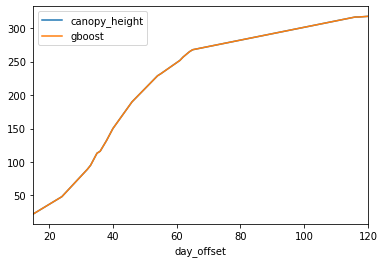

In [291]:
plot_specific_cultivar(6000000207, 3, 39)

(9, 10)
            canopy_height      gboost
day_offset                           
14                   17.0   17.001946
18                   25.0   25.001336
32                   83.0   83.000069
33                   92.0   91.999766
35                  103.0  102.999240
36                  103.0  102.999240
38                   98.0   97.999908
39                  100.0   99.999590
45                  124.0  123.998905
cultivar = 0.0
day_offset = 0.9816231179970161
range = 0.0
column = 0.0
leaf_angle_alpha = 0.0069385988263879405
leaf_angle_beta = 0.0021028904217576527
leaf_angle_chi = 0.007547074015750632
leaf_angle_mean = 0.0017883187390877555


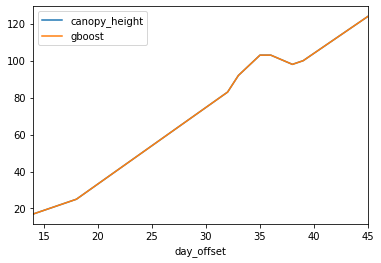

In [301]:
plot_specific_cultivar(6000000976,2,45)

**the above plots show that a gradient boost model can precisely fit the observed data when trained on only the particular cultivar and location measurements.** This isn't too much of a surprise.  It shows that a single model for the whole field  can't match as well (at least when using the cultivar as an integer variable).  Ideally, we should have one-hot encoded the cultivar as a categorical variable. 

How to find the feature importances.  This is an output of the trained model. Lets look at one before we add it to the plot

In [293]:
feature_names = ['cultivar','day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']
for name, importance in zip(feature_names, gbr_models[(6000000976,2,45)].feature_importances_):
    print(name, "=", importance)

cultivar = 0.0
day_offset = 0.9816231179970161
range = 0.0
column = 0.0
leaf_angle_alpha = 0.0069385988263879405
leaf_angle_beta = 0.0021028904217576527
leaf_angle_chi = 0.007547074015750632
leaf_angle_mean = 0.0017883187390877555


Unsurprisingly, the day, which represents how far into the growing season we are, is by far (98%) the most driving factor of calculating the model result.

In [295]:

def plot_specific_cultivar(cultivar,col,rng):
    feature_names = ['cultivar','day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']
    df = predictions[(cultivar,col,rng)]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    print(df.shape)
    df = df[['day_offset','canopy_height','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()
    for name, importance in zip(feature_names, gbr_models[(cultivar,col,rng)].feature_importances_):
        print(name, "=", importance)

(9, 10)
            canopy_height      gboost
day_offset                           
14                   17.0   17.001946
18                   25.0   25.001336
32                   83.0   83.000069
33                   92.0   91.999766
35                  103.0  102.999240
36                  103.0  102.999240
38                   98.0   97.999908
39                  100.0   99.999590
45                  124.0  123.998905
cultivar = 0.0
day_offset = 0.9816231179970161
range = 0.0
column = 0.0
leaf_angle_alpha = 0.0069385988263879405
leaf_angle_beta = 0.0021028904217576527
leaf_angle_chi = 0.007547074015750632
leaf_angle_mean = 0.0017883187390877555


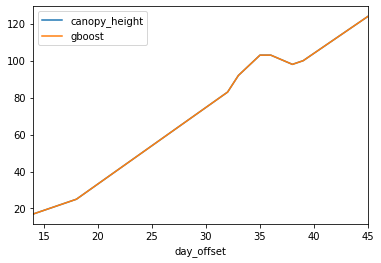

In [296]:
plot_specific_cultivar(6000000976,2,45)

In [46]:
full_df.columns

Index(['canopy_height', 'column', 'cultivar', 'date', 'leaf_angle_alpha',
       'leaf_angle_beta', 'leaf_angle_chi', 'leaf_angle_mean', 'range',
       'season', 'day_offset'],
      dtype='object')

**test how to convert column to categorical**

In [ ]:
# make sure the cultivar is a categorical type variable
full_df = full_df[['cultivar','column','range','date','season','day_offset','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
full_df['cultivar'] = pd.Categorical(full_df['cultivar'])
full_df.dtypes

In [308]:
train = full_df
for col in train.dtypes[train.dtypes == 'category'].index:
    for_dummy = train.pop(col)
    train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

## train-test splitting on time sequence data?

Sci-kit learn includes a special TimeSeriesSplit operation that takes more of the sequence for training each time, and pulls the 'immediately after training' value for the testing prediction.  This will train on a small subset of the input originally and eventually use most of the input for training.  Overall, it will yield an accuracy representative of querying at any time during the sequence. 

The problem of using this on the separated cultivar-range-column models is that very few datapoints are available for training. If we further reduce the number of points through train/test split, accuracy could suffer.  However, it is representative of the data available at each point during the season, so this is realistic.  Let's modify the training above  to use a train/test split.  At the same time, lets one-hot encode the cultivars.

In [309]:
train.columns

Index(['column', 'range', 'date', 'season', 'day_offset', 'leaf_angle_alpha',
       'leaf_angle_beta', 'leaf_angle_chi', 'leaf_angle_mean',
       'cultivar_6000000207',
       ...
       'cultivar_6000001029', 'cultivar_6000001054', 'cultivar_6000001055',
       'cultivar_6000001056', 'cultivar_6000001057', 'cultivar_6000001059',
       'cultivar_6000001060', 'cultivar_6000001061', 'cultivar_6000001062',
       'cultivar_6000001063'],
      dtype='object', length=360)

In [84]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import GradientBoostingRegressor
#warnings.warn(NSPLIT_WARNING, FutureWarning)

gbr_models2 = {}
predictions2 = {}
count = 0
grouped2 = full_df.groupby(['cultivar','column','range'])
for name,group in grouped2:
    #print(name)
    # pick the features to use for training
    train_df = group[['cultivar','day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
    train_df['cultivar'] = pd.Categorical(train_df['cultivar'])
    # identify the 'target' feature to try to predict
    target_df = group['canopy_height']
    if len(train_df) > 20:
        X = train_df.values
        y = target_df.values
        count += 1
        print('shape X:',X.shape,' y:',y.shape)
        tss= TimeSeriesSplit(n_splits=2)
        #tss= ShuffleSplit()
        print("X_train:",X_train,"y_train:",y_train)
        print("X_test:",X_test,"y_test:",y_test)
        for train_index, test_index in tss.split(X):
            print(train_index,test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # train a model for this cultivar in this location and store the trained model in a dictionary
            gbr_models2[name] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)
            gbr_pred = gbr_models2[name].predict(X_test)
            print('predictions:',gbr_pred)

            predictions2[name] = gbr_models2[name].score(X_test,y_test)
            #print('training set score: {:.2f}'.format(gbr_models2[name].score(X_train,y_train)))
            #print('test set score: {:.2f}'.format(gbr_models2[name].score(X_test,y_test)))
    if count > 2:
        break
print('finished generating',count,'models')

/Users/curtislisle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


shape X: (21, 8)  y: (21,)
X_train: [[6000000464 15.0 51 3 3.25326410587 2.15918306701 1.84380257819
  0.414221305212]
 [6000000464 18.0 51 3 2.94826514793 2.01419013348 1.8075966298400004
  0.431598041787]
 [6000000464 23.0 51 3 1.7511163258900002 1.66705407447 1.54119024613
  0.494613883754]
 [6000000464 24.0 51 3 2.19170262675 1.8679376954499998 1.62562900495
  0.469079643023]
 [6000000464 32.0 51 3 3.5928799038999997 2.1606193934299998 1.9283146553
  0.40532649796400005]
 [6000000464 34.0 51 3 3.20477135316 2.03687477467 1.88394704345
  0.41585510941200005]
 [6000000464 36.0 51 3 3.40775289944 2.1041825957299998 1.90204810526
  0.41438958781199997]
 [6000000464 38.0 51 3 4.2124949121599995 2.25164810824
  2.0604689307900004 0.38107418415399996]
 [6000000464 39.0 51 3 3.23512994709 1.99929908999 1.9224658635
  0.412805160034]
 [6000000464 40.0 51 3 2.77639680201 1.85075021058 1.8885756006299999
  0.41510408940300003]
 [6000000464 41.0 51 3 3.0595421391400004 1.86790320508 1.95027669

/Users/curtislisle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/curtislisle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


shape X: (21, 8)  y: (21,)
X_train: [[6000000229 15.0 43 12 2.5739754989400003 1.8378362654499998
  1.79587079551 0.438646405863]
 [6000000229 18.0 43 12 3.68080075639 2.36744244885 1.8551067013799998
  0.408555911681]
 [6000000229 32.0 43 12 3.52156761947 2.1588869598700002 1.89949729715
  0.41174904805699997]
 [6000000229 33.0 43 12 4.11011620995 2.32867843901 2.0060039562
  0.37723714851400003]
 [6000000229 35.0 43 12 4.54148736417 2.4329015929599995 2.07938224024
  0.356822503129]
 [6000000229 36.0 43 12 4.8873069110300005 2.58521277077 2.05632344159
  0.36767477536700005]
 [6000000229 38.0 43 12 5.14698001254 2.3288985602900003
  2.2908886088599996 0.333142630973]
 [6000000229 39.0 43 12 4.25946949764 2.26784149806 2.10182262649
  0.358463821769]
 [6000000229 40.0 43 12 3.8964829147300004 2.22098511942 2.00247878339
  0.384768582025]
 [6000000229 45.0 43 12 2.8163682310900002 1.8628993201
  1.8573201705000002 0.429078241983]
 [6000000229 117.0 43 12 2.24453098158 1.581490835820000

In [81]:
predictions2

{(6000000228, 14, 40): 0.13974181153960463,
 (6000000229, 12, 43): 0.19126496002314552,
 (6000000464, 3, 51): -0.29243135338180615}

In [310]:
train.head()

,column,range,date,season,day_offset,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,cultivar_6000000207,...,cultivar_6000001029,cultivar_6000001054,cultivar_6000001055,cultivar_6000001056,cultivar_6000001057,cultivar_6000001059,cultivar_6000001060,cultivar_6000001061,cultivar_6000001062,cultivar_6000001063
2017-05-13 12:00:00,2,43,2017-05-13 12:00:00,4,12,2.695956,1.977380,1.756464,0.435924,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-13 12:00:00,15,35,2017-05-13 12:00:00,4,12,3.265980,2.018623,1.941012,0.396782,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-13 12:00:00,2,42,2017-05-13 12:00:00,4,12,2.159610,1.809209,1.638744,0.471944,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-13 12:00:00,4,30,2017-05-13 12:00:00,4,12,3.042180,2.198751,1.732985,0.444099,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-15 12:00:00,2,45,2017-05-15 12:00:00,4,14,2.305345,1.872028,1.665387,0.462600,0,...,0,0,0,0,0,0,0,0,0,0


In [311]:
train.tail()

,column,range,date,season,day_offset,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,cultivar_6000000207,...,cultivar_6000001029,cultivar_6000001054,cultivar_6000001055,cultivar_6000001056,cultivar_6000001057,cultivar_6000001059,cultivar_6000001060,cultivar_6000001061,cultivar_6000001062,cultivar_6000001063
2017-07-04 12:00:00,3,48,2017-07-04 12:00:00,4,64,2.668148,1.771867,1.910103,0.405739,0,...,0,0,0,0,0,0,0,0,0,0
2017-07-04 12:00:00,4,48,2017-07-04 12:00:00,4,64,1.961894,1.573487,1.722770,0.466432,0,...,0,0,0,0,0,0,0,0,0,0
2017-07-04 12:00:00,7,49,2017-07-04 12:00:00,4,64,3.069223,2.013949,1.869177,0.415079,0,...,0,0,0,0,0,0,0,0,0,0
2017-07-04 12:00:00,12,49,2017-07-04 12:00:00,4,64,1.109560,1.352693,1.389389,0.542211,0,...,0,0,0,0,0,0,0,0,0,0
2017-07-04 12:00:00,15,54,2017-07-04 12:00:00,4,64,4.107072,2.462428,1.925890,0.393302,0,...,0,0,1,0,0,0,0,0,0,0
